In [1]:
import sys
sys.path.append('../xrun')

In [2]:
import re

from pathlib import Path

import numpy as np
import numba
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from IPython.core.display import HTML
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs

from xrun.data.run_info import RunInfo
from xrun.data.loader import load_dataset

In [3]:
centers = np.random.randint(low=2, high=10)
raw_data, _ = make_blobs(n_samples=2000, centers=centers)

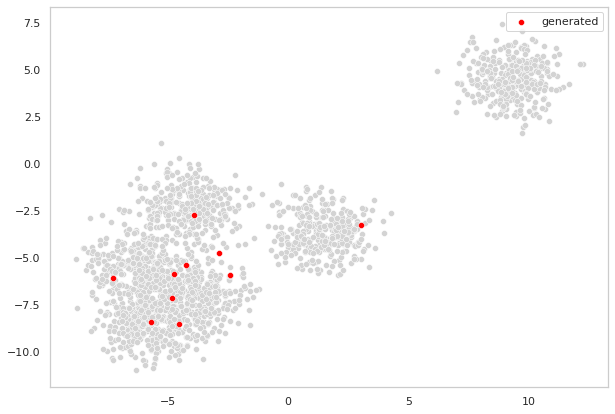

In [4]:

n_points = raw_data.shape[0]
indices = np.arange(start=0, stop=n_points)
generated_points = []
for i in range(10):
    n_points = raw_data.shape[0]
    new_size = 2 # n_points# 5 # int(n_points * 0.02)
    random_vector = np.random.rand(new_size, 1)
    proba_vector = random_vector / random_vector.sum()
    
    random_selection = np.random.choice(indices, new_size)
    new_point = np.dot(proba_vector.T, raw_data[random_selection])
    generated_points.append(new_point)

generated_points = np.array(generated_points).squeeze()

#proba_vector
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x=raw_data[:,0], y=raw_data[:,1], color="lightgrey", ax=ax)
sns.scatterplot(x=generated_points[:,0], y=generated_points[:,1], color='red', label="generated", ax=ax)
# ax.set_ylim([-15, 15])
# ax.set_ylim([-15, 15])
ax.grid(False)

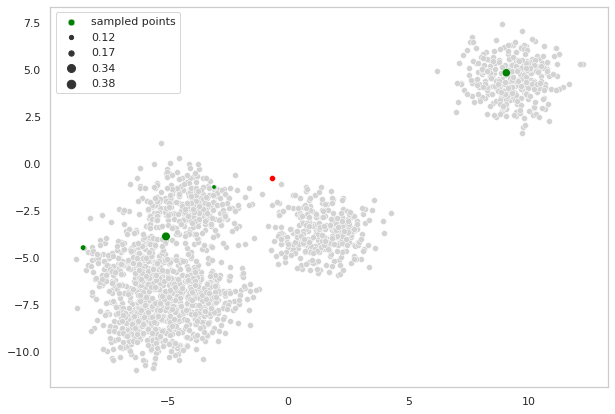

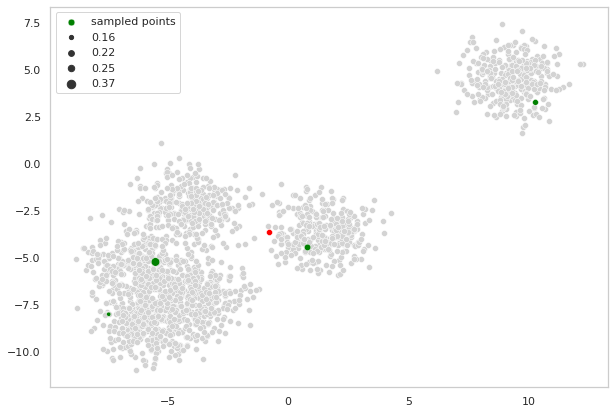

In [5]:

for i in range(2):
    n_points = raw_data.shape[0]
    new_size = 4 # int(n_points * 0.02)
    random_vector = np.random.rand(new_size, 1)
    proba_vector = random_vector / random_vector.sum()
    
    random_selection = np.random.choice(indices, new_size)
    new_point = np.dot(proba_vector.T, raw_data[random_selection])
    
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.scatterplot(x=raw_data[:,0], y=raw_data[:,1], color="lightgrey", ax=ax)
    sns.scatterplot(x=new_point[:,0], y=new_point[:,1], color='red', ax=ax)
    sns.scatterplot(x=raw_data[random_selection][:,0], y=raw_data[random_selection][:,1], 
                    size=proba_vector.round(2).squeeze(), color='green', label="sampled points", ax=ax)
    ax.grid(False)